In [10]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /root/.julia/packages/Revise/lwch5/src/Revise.jl:866
┌ Warning: Package FEniCS does not have PyPlot in its dependencies:
│ - If you have FEniCS checked out for development and have
│   added PyPlot as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FEniCS
│ Loading PyPlot into FEniCS from project dependency, future warnings for FEniCS are suppressed.
└ @ nothing nothing:904
┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:410
└ @ PyCall /root/.julia/packages/PyCall/BcTLp/src/PyCall.jl:410
┌ Warning: Error requiring PyPlot from FEniCS:
│ LoadError: @pyimport: fenics already defined
│ Stacktrace:
│  [1] error(::String, ::Symbol, ::String) at ./error.jl:42
│  [2] top-level scope at /root/.julia/packages/PyCall/BcTLp/src/PyCall.jl:593
│  

In [15]:
function twopanel(xgrid, ygrid, npts, U, S, idx, els)
    # Start of nice visualization
    figure(figsize=(12,3))
    subplot(1, 2, 1)
    field = sqrt.(U[:, 1].^2 + U[:, 2].^2)
    ncontours = 10
    lowfield = 0
    highfield = 100
    ncontours = LinRange(lowfield, highfield, 11)    

    xlim = [-20000 20000]
    ylim = [-20000 2000]
    scale = 1.0
    fieldmax = maximum(@.abs(field))
    contourf(reshape(xgrid, npts, npts), reshape(ygrid, npts, npts),
             reshape(field, npts, npts), ncontours,
             vmin=lowfield, vmax=highfield,
             cmap = get_cmap("magma"))
    clim(lowfield, highfield)
    colorbar(fraction=0.020, pad=0.05, extend = "both", label = L"$||u||$ (m)")
    contour(reshape(xgrid, npts, npts), reshape(ygrid, npts, npts),
            reshape(field, npts, npts), ncontours,
            vmin=lowfield, vmax=highfield,
            linewidths=0.25, colors="w")
    plotelements(els)
    gca().set_aspect("equal")
    gca().set_xlim([xlim[1], xlim[2]])
    gca().set_ylim([ylim[1], ylim[2]])
    gca().set_xticks([-20000, -10000, 0, 10000, 20000])
    gca().set_yticks([-20000, -10000, 0])
    xlabel(L"$x$ (m)")
    ylabel(L"$y$ (m)")
    xv = [els.x1[idx["T"]] ; els.x2[idx["T"]][end] ; 20000 ; -20000]
    yv = [els.y1[idx["T"]] ; els.y2[idx["T"]][end]; 2000 ; 2000]
    fill(xv, yv, "lightgray", zorder=30)

    # Find principle stress orientations
    stressdiff = zeros(length(U[:, 1]))
    for i in 1:length(U[:,1])
        mat = [S[i, 1] S[i, 3]; S[i, 3] S[i, 2]]
        ev = eigvals(mat)
        stressdiff[i] = log10(abs(ev[2]-ev[1]))
    end
    
    subplot(1, 2, 2)
    field = stressdiff
    xlim = [-20000 20000]
    ylim = [-20000 2000]
    lowfield = 5
    highfield = 10
    ncontours = LinRange(lowfield,highfield, 11)    
    contourf(reshape(xgrid, npts, npts), reshape(ygrid, npts, npts),
             reshape(field, npts, npts), ncontours,
             vmin=lowfield, vmax=highfield,
             cmap=get_cmap("viridis"))
    clim(lowfield, highfield)
    colorbar(fraction=0.020, pad=0.05, extend="both",
             label=L"$\Delta \sigma$ (Pa)")
    contour(reshape(xgrid, npts, npts), reshape(ygrid, npts, npts),
            reshape(field, npts, npts), ncontours,
            vmin=lowfield, vmax=highfield,
            linewidths=0.25, colors="w")
    plotelements(els)
    gca().set_aspect("equal")
    gca().set_xlim([xlim[1], xlim[2]])
    gca().set_ylim([ylim[1], ylim[2]])
    gca().set_xticks([-20000, -10000, 0, 10000, 20000])
    gca().set_yticks([-20000, -10000, 0])
    xlabel(L"$x$ (m)")
    ylabel(L"$y$ (m)")
    xv = [els.x1[idx["T"]] ; els.x2[idx["T"]][end] ; 20000 ; -20000]
    yv = [els.y1[idx["T"]] ; els.y2[idx["T"]][end]; 2000 ; 2000]
    fill(xv, yv, "lightgray", zorder=30)
    tight_layout()
    return nothing
end

twopanel (generic function with 1 method)

In [74]:
mu = 30e9
lambda = 30e9
nu = 0.25
g = 9.81
rho = 2700
alpha = 1e-7 # scalar preconditioner
npts = 200
offset = 1
B = -20e3 # Bottom
R = 20e3 # Right
T = 0e3 # Top
L = -20e3 # Left

-20000.0

In [75]:
using FEniCS
using PyCall
function interior_eval(u, x, y)
    py"""
    def G(u, x, y):
        return u(x, y)
    """
    py"G"(u.pyobject, x, y)
end


# Calculate strain
function strain(u)
    0.5 * (nabla_grad(u) + FEniCS.Transpose(nabla_grad(u)))
end


# Calculate
function stress(u, lambda, mu)
     lambda * nabla_div(u) * Identity(2) + 2 * mu * strain(u)
end

stress (generic function with 1 method)

In [76]:
mesh = RectangleMesh(Point((1.5 * L, T + (T - B) * 0.5)), Point((1.5 * R, 1.5 * B)), 100, 100)
V = VectorFunctionSpace(mesh, "P", 1)
function solve_fenics(L, T, R, B)
    # Create mesh and define function space
 
    bc = DirichletBC(V, Constant((0, 0)), "on_boundary") # What BCs are bing set???

    # Solve
    u = TrialFunction(V)
    d = geometric_dimension(u) # space dimension
    v = TestFunction(V)
    f = Constant((0, -rho * g)) # Vector of uniform body force
    T = Constant((0, 0))
    a = inner(stress(u, lambda, mu), strain(v)) * dx
    L = dot(f, v) * dx + dot(T, v) * ds
    u = FeFunction(V)
    lvsolve(a, L, u, bc)
    return u
end
u = solve_fenics(L, T, R, B)

Solving linear variational problem.


"Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 134), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 143)"

In [77]:
function fem_interior_eval(f, x, y)
    py"""
    def G(f, x, y):
        return f(x, y)
    """
    py"G"(f.pyobject, x, y)
end

fem_interior_eval (generic function with 1 method)

In [78]:
sxx_sxy = project(dot(stress(u, lambda, mu), Constant((1,0))), V)
sxy_syy = project(dot(stress(u, lambda, mu), Constant((0,1))), V)

"Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 134), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 180)"

In [79]:
# Element geometries and data structures for the box case
elsbox = Elements(Int(1e5))
nfault = 1
nside = 50

# From thrust fault example
x1T, y1T, x2T, y2T = discretizedline(-20e3, 0, 20e3, 0, nside)
y1T = -1e3 * atan.(x1T / 1e3)
y2T = -1e3 * atan.(x2T / 1e3)
# y1T = zeros(length(y1T))
# y2T = zeros(length(y2T))

xgrid, ygrid = obsgrid(L+offset, B+offset, R-offset, maximum(y1T)-offset, npts)

x1, y1, x2, y2 = discretizedline(L, B, R, B, nside) # Bottom
addelsez!(elsbox, x1, y1, x2, y2, "B")
x1, y1, x2, y2 = discretizedline(R, B, R, minimum(y2T), nside) # Right hand side
addelsez!(elsbox, x1, y1, x2, y2, "R")
addelsez!(elsbox, x1T, y1T, x2T, y2T, "T")
x1, y1, x2, y2 = discretizedline(L, maximum(y1T), L, B, nside) # Left hand side
addelsez!(elsbox, x1, y1, x2, y2, "L")
x1, y1, x2, y2 = discretizedline(-10e3, -10e3, -5e3, -5e3, nfault) # 45 degree dipping fault
addelsez!(elsbox, x1, y1, x2, y2, "F")
idxbox = getidxdict(elsbox);

getidx found 50 elements with label "B"
getidx found 50 elements with label "R"
getidx found 50 elements with label "T"
getidx found 50 elements with label "L"
getidx found 1 elements with label "F"


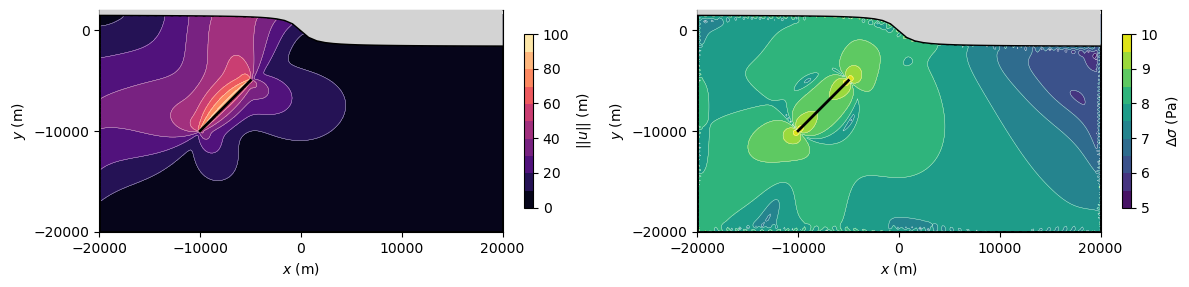

In [80]:
BRTL_idx = [idxbox["B"] ; idxbox["R"] ; idxbox["T"] ; idxbox["L"]]
### Fault only
### R, T, L are traction free bcs
### B is zero slip BC
T_TB_F, H_TB_F = PUTC(slip2dispstress, elsbox, BRTL_idx, idxbox["F"], mu, nu)
Fslip = [100; 100]; # y-direction slip only
Uslip = T_TB_F * Fslip
Tslip = H_TB_F * Fslip

# Kernels and solve
T_B_BRTL, H_B_BRTL = PUTC(slip2dispstress, elsbox, idxbox["B"], BRTL_idx, mu, nu)
T_RTL_BRTL, H_RTL_BRTL = PUTC(slip2dispstress, elsbox, [idxbox["R"]; idxbox["T"]; idxbox["L"]], BRTL_idx, mu, nu)
bcsbox = zeros(8 * nside)
bcsbox[1:2*nside] = -Uslip[1:2*nside] # Bottom
bcsbox[2*nside+1:4*nside] = -Tslip[2*nside+1:4*nside] # Right
bcsbox[4*nside+1:6*nside] = -Tslip[4*nside+1:6*nside] # Top
bcsbox[6*nside+1:8*nside] = -Tslip[6*nside+1:8*nside] # Left
THbox = [T_B_BRTL ; H_RTL_BRTL]
Ueffbox = THbox \ bcsbox

# Volume evaluation
UTB, STB = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, BRTL_idx,
                           Ueffbox[1:2:end], Ueffbox[2:2:end], mu, nu)
UF, SF = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, idxbox["F"],
                         Fslip[1:2:end], Fslip[2:2:end], mu, nu)
Ufaultonly = UTB .+ UF
Sfaultonly = STB .+ SF
twopanel(xgrid, ygrid, npts, Ufaultonly, Sfaultonly, idxbox, elsbox);

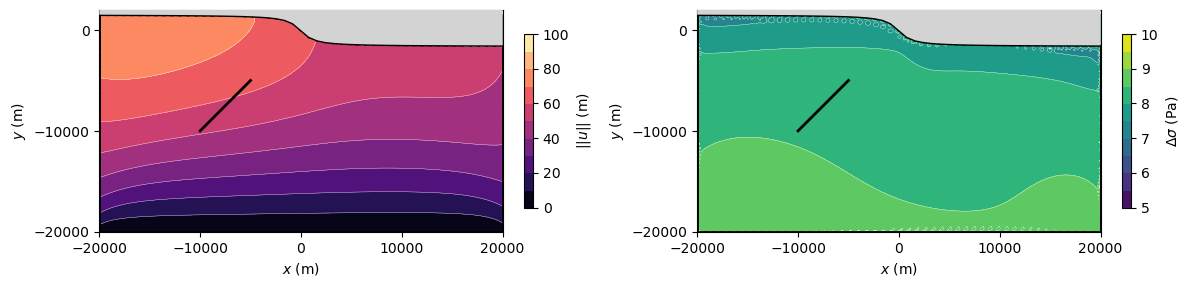

In [81]:
### Box BEM problem (no dislocation, gravity only)
# Displacement BCs for bottom
Ug, Sg = gravityparticularfunctions(elsbox.xcenter[idxbox["B"]],
                                    elsbox.ycenter[idxbox["B"]],
                                    g, rho, lambda, mu)    
bcsboxgravity = zeros(2 * elsbox.endidx - 2)
bcsboxgravity[1:2:2*nside] = Ug[:, 1]
bcsboxgravity[2:2:2*nside] = Ug[:, 2]

# Traction BCs for top and sides
Ug, Sg = gravityparticularfunctions(elsbox.xcenter[idxbox["T"]],
                                    elsbox.ycenter[idxbox["T"]],
                                    g, rho, lambda, mu)  
Ttx = zeros(nside)
Tty = zeros(nside)
for i in 1:length(Sg[:, 1])
    nvec = [elsbox.xnormal[idxbox["T"][i]] ; elsbox.ynormal[idxbox["T"][i]]]
    temp = [Sg[i, 1] Sg[i, 3] ; Sg[i, 3] Sg[i, 2]] * nvec
    Ttx[i] = temp[1]
    Tty[i] = temp[2]
end
bcsboxgravity[4*nside+1:2:6*nside] = Ttx
bcsboxgravity[4*nside+2:2:6*nside] = Tty
bcsboxgravity *= -1
Ueffboxparticular = THbox \ bcsboxgravity  

Ucomp, Scomp = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               [idxbox["B"] ; idxbox["R"] ; idxbox["T"] ; idxbox["L"]],
                               Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu)
Uint, Sint = gravityparticularfunctions(xgrid, ygrid, g, rho, lambda, mu)
Ugravityonly = @. Ucomp + Uint
Sgravityonly = @. Scomp + Sint
twopanel(xgrid, ygrid, npts, Ugravityonly, Sgravityonly, idxbox, elsbox)

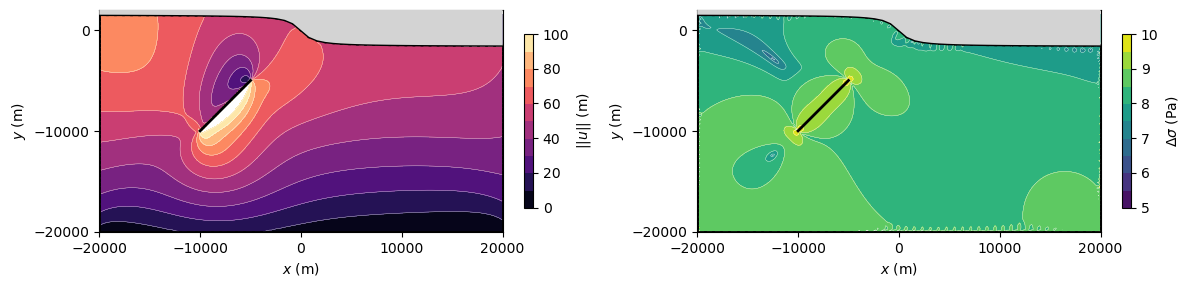

In [82]:
### Box BEM problem (dislocation and gravity)
bcscombined = bcsboxgravity .+ bcsbox    
Ueffcombined = THbox \ bcscombined
Ucomp, Scomp = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               BRTL_idx, Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu)
Ugravityfault = Ucomp .+ Uint .+ UF
Sgravityfault = Scomp .+ Sint .+ SF
twopanel(xgrid, ygrid, npts, Ugravityfault, Sgravityfault, idxbox, elsbox)

In [83]:
function fem_eval_u(idx, x, y)
    n = length(idx)
    fem_eval = zeros(2*n)
    for idx_i in 1:n
        i = idx[idx_i]
        fem_eval[(2*idx_i - 1):(2*idx_i)] = interior_eval(u, x[i], y[i])
    end
    return fem_eval
end
function fem_eval_t(idx, x, y, xn, yn)
    n = length(idx)
    fem_eval = zeros(2*n)
    for idx_i in 1:n
        i = idx[idx_i]
        sxx, sxy = fem_interior_eval(sxx_sxy, x[i], y[i])
        sxy2, syy = fem_interior_eval(sxy_syy, x[i], y[i])
        tx = sxx * xn[i] + sxy * yn[i]
        ty = sxy * xn[i] + syy * yn[i]
        fem_eval[2*idx_i - 1] = tx
        fem_eval[2*idx_i] = ty
    end
    return fem_eval
end
bcs_B = -fem_eval_u(idxbox["B"], elsbox.xcenter, elsbox.ycenter)
bcs_RTL = -fem_eval_t([idxbox["R"]; idxbox["T"]; idxbox["L"]], elsbox.xcenter, elsbox.ycenter, elsbox.xnormal, elsbox.ynormal);

In [84]:
bcsboxgravityfem = zeros(2 * elsbox.endidx - 2)
bcsboxgravityfem[1:2*nside] = bcs_B
bcsboxgravityfem[2*nside+1:end] = bcs_RTL;

In [85]:
Ueffboxparticular = THbox \ bcsboxgravityfem 
Ubox, Sbox = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               BRTL_idx, Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu);

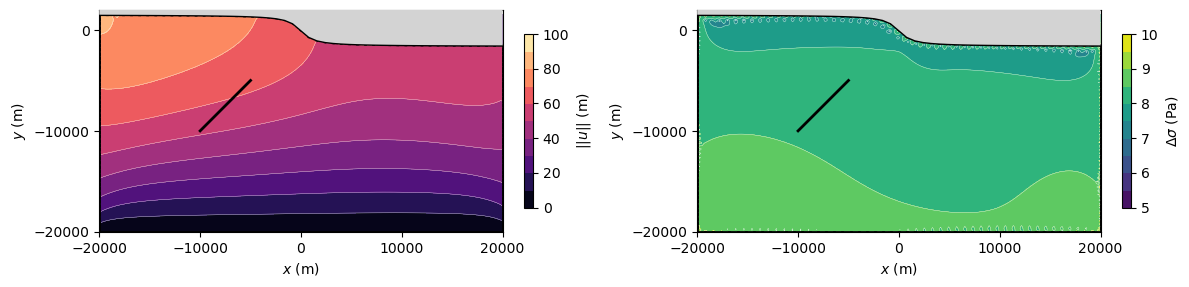

In [86]:
n = length(xgrid)
Ufem = zero(Ubox)
Sfem = zero(Sbox)
for i in 1:n
    ux, uy = fem_interior_eval(u, xgrid[i], ygrid[i])
    sxx,sxy = fem_interior_eval(sxx_sxy, xgrid[i], ygrid[i])
    sxy2,syy = fem_interior_eval(sxy_syy, xgrid[i], ygrid[i])
    Ufem[i, 1] += ux
    Ufem[i, 2] += uy
    Sfem[i, 1] += sxx
    Sfem[i, 3] += sxy
    Sfem[i, 2] += syy
end
Ufem_gravity_only = Ubox + Ufem
Sfem_gravity_only = Sbox + Sfem
twopanel(xgrid, ygrid, npts, Ufem_gravity_only, Sfem_gravity_only, idxbox, elsbox);

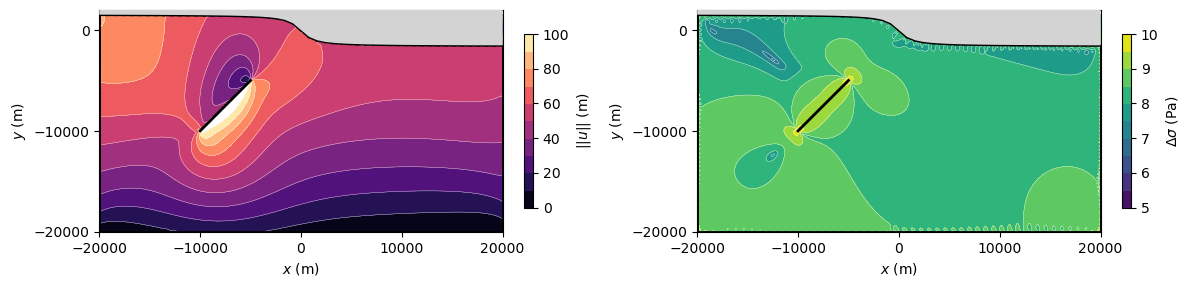

In [87]:
### Box BEM problem (dislocation and gravity)
bcscombined = bcsboxgravityfem .+ bcsbox    
Ueffcombined = THbox \ bcscombined
Ucomp, Scomp = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               [idxbox["B"] ; idxbox["R"] ; idxbox["T"] ; idxbox["L"]],
                               Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu)
Ugravityfault = Ucomp .+ Ufem .+ UF
Sgravityfault = Scomp .+ Sfem .+ SF
twopanel(xgrid, ygrid, npts, Ugravityfault, Sgravityfault, idxbox, elsbox)